# ESTI019 - Codificação de Sinais Multimídia
# Lab8 - Codificação de Voz e Áudio
## Profs. Celso S. Kurashima e Mário Minami

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2> OBJETIVOS </h2>
. Determinação dos parâmetros LPC
. Separação Sonora/Surda
. Espectro e Envoltória LP
. Comparação de Codificações MPEG


In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display
import math

## Separação de uma Estrofe

In [4]:
audio1 = '/content/drive/MyDrive/ColabCSM/JonasGrecoOnias.wav'
print(audio1)
v1 , sr1 = librosa.load(audio1)
print(type(v1), type(sr1))
print(v1.shape, sr1)
# Player será aberto! AGUARDE até abrir!
IPython.display.Audio(data=v1, rate=sr1)

/content/drive/MyDrive/ColabCSM/JonasGrecoOnias.wav
<class 'numpy.ndarray'> <class 'int'>
(56064,) 22050


Text(0.5, 1.0, 'Sobrenome/content/drive/MyDrive/ColabCSM/JonasGrecoOnias.wav')

<Figure size 432x288 with 0 Axes>

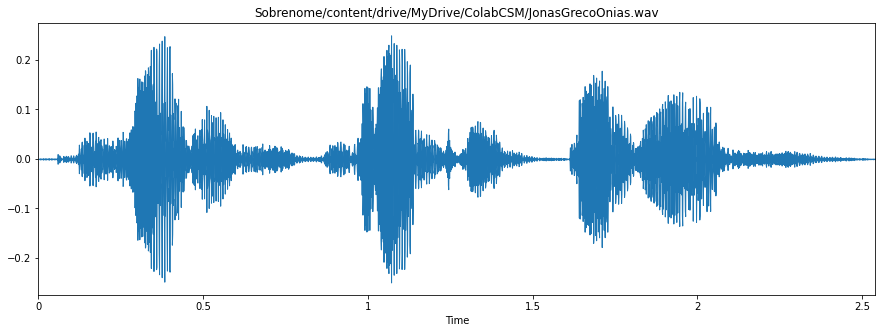

In [5]:
plt.figure()
fig, ax = plt.subplots(figsize=(15, 5))
librosa.display.waveplot(v1, sr=sr1)
plt.title('Sobrenome' + audio1)

In [6]:
fa = sr1
Ts = 0.04
Nj = int(Ts*fa)
Nseg = int(len(v1)/Nj)
Nover = int(Nj*0.5)

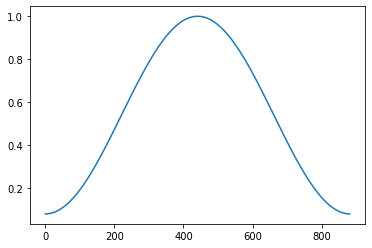

In [7]:
from scipy import signal
hm = signal.get_window('hamming', Nj)
plt.plot(hm)

<class 'numpy.ndarray'> <class 'int'>
(13000,) 22050


<Figure size 432x288 with 0 Axes>

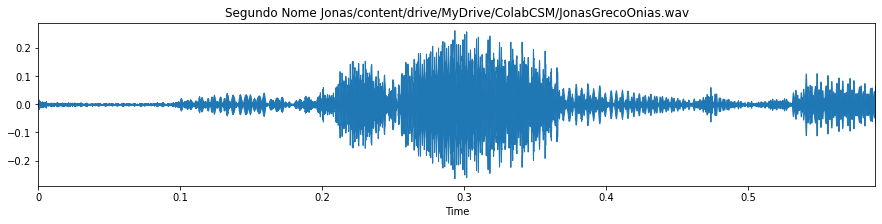

In [8]:
# Só a primeira estrofe
v11 = v1[17000:30000]
plt.figure()
fig11, ax11 = plt.subplots(figsize=(15, 3))
librosa.display.waveplot(v11, sr=sr1)
plt.title('Segundo Nome Jonas' + audio1)
print(type(v11), type(sr1))
print(v11.shape, sr1)
# Player será aberto! AGUARDE até abrir!
IPython.display.Audio(data=v11, rate=sr1)

## Cálculo dos Parâmetros LPC, separação U/UV e Espectro + Envoltória LPC

In [9]:
!pip install audiolazy
import audiolazy as lz

  Using cached https://files.pythonhosted.org/packages/65/97/0b9528016ce0d4d11380d9864b6fe3b3f7d8b358a841e3489fa84fd18792/audiolazy-0.6-py2.py3-none-any.whl


Limiar VAD 32.41329802347475
Limiar U/UV 39.113298023474755
Sonoros = 3 e Surdos = 4


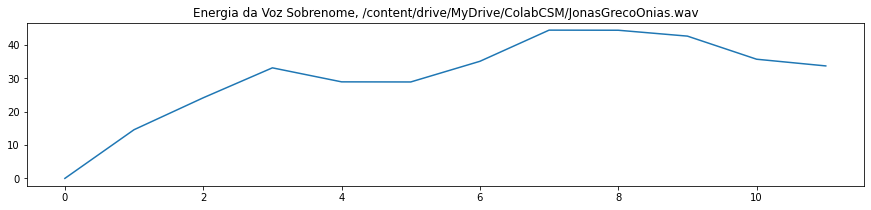

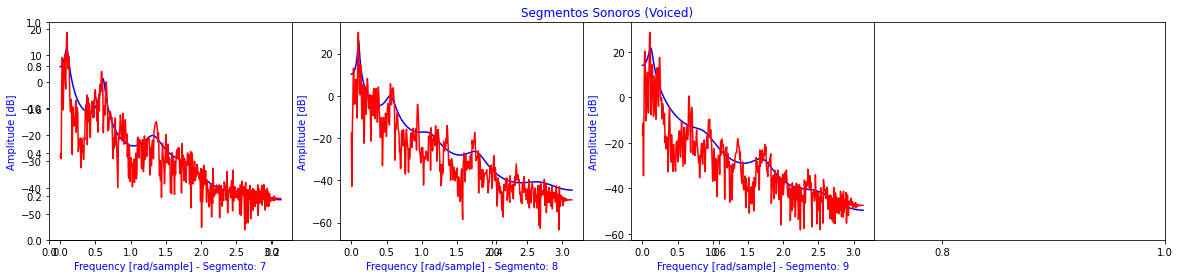

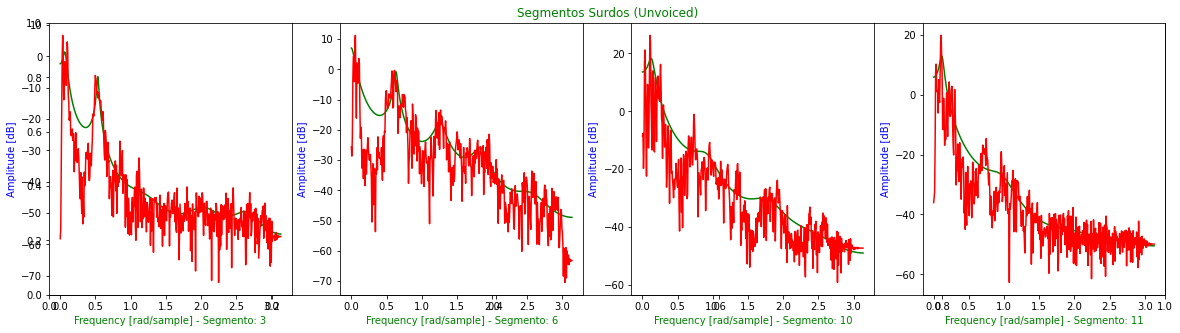

In [16]:
Nover = int(Nj*0.5)
Nseg1 = int(len(v11)/Nj)
p = 10
E = []
ind_voz = [0]*Nseg1
t = np.arange(Nj)
for l in range(1, Nseg1-1):
    xjan = v1[(l-1)*Nj+Nover:l*Nj+Nover]*hm
    x2 = list(np.array(xjan**2))
    aux = sum(x2)/Nj
    E.append(aux)
E1 = 10*np.log10(E)
E1min = np.min(E1)
E1 = E1 - E1min   # Coloca o ruído de fundo em 0 dB
E1max = np.max(E1)
# limiar de atividade VAD
E1VAD_lim = E1max - 12 #8
print('Limiar VAD ' + str(E1VAD_lim))
# Limiar U/UV ajustado para 30% do máximo
E1voiced_lim = E1max - 5.3
print('Limiar U/UV ' + str(E1voiced_lim))
# indicador de VAD
ind_voz = np.where(E1 > E1VAD_lim, 1, 0)
ind_voiced = np.where(E1 > E1voiced_lim, 1, 0)
tot_voz = np.sum(ind_voz)
num_voiced = np.sum(ind_voiced)
num_unvoiced = tot_voz - num_voiced
linhas_voiced = math.ceil(num_voiced/4)
linhas_unvoiced = math.ceil(num_unvoiced/4)

print('Sonoros = ' + str(num_voiced) + ' e Surdos = ' + str(num_unvoiced) )
fig1, ax1 = plt.subplots(figsize=(15, 3))
plt.figure(1)
plt.plot(E1)
plt.title('Energia da Voz Sobrenome, ' + audio1)

# partição das figuras voiced
i = 0
fig2, ax2 = plt.subplots(figsize=(20, num_voiced + linhas_voiced))
plt.title('Segmentos Sonoros (Voiced)', color = 'b')

# partição das figuras unvoiced
j = 0
fig3, ax3 = plt.subplots(figsize=(20, num_unvoiced + linhas_unvoiced))
plt.title('Segmentos Surdos (Unvoiced)', color = 'g')

for l in range(1, Nseg1-2):
    # teste de VAD 
    if ind_voz[l] == 1:
        xjan = v1[(l-1)*Nj+Nover:l*Nj+Nover]*hm
        a_filter = lz.lpc.kautocor(xjan, p) 
        gain_lpc = np.log10(abs(a_filter.error))
        w, h = signal.freqz(1,a_filter.numerator,worN=int(Nj/2))
        LP = 20 * np.log10(abs(h)) + 10*gain_lpc
        # Teste U/UV
       
        if E1[l] > E1voiced_lim:
            
            i += 1
            ax2 = fig2.add_subplot(linhas_voiced,4,i) 
            plt.figure(2)          
            plt.plot(w, LP, 'b')
            plt.ylabel('Amplitude [dB]', color='b')
            plt.xlabel('Frequency [rad/sample] - Segmento: ' + str(l), color='b')     
            sp = np.fft.fft(xjan)
            plt.plot(w, 20*np.log10(abs(sp[0:int(Nj/2)])), 'r')
            
        else:
            
            j += 1
            ax3 = fig3.add_subplot(linhas_unvoiced,4,j)           
            plt.figure(3)            
            plt.plot(w, LP, 'g')
            plt.ylabel('Amplitude [dB]', color='b')
            plt.xlabel('Frequency [rad/sample] - Segmento: ' + str(l), color='g')     
            sp = np.fft.fft(xjan)
            plt.plot(w, 20*np.log10(abs(sp[0:int(Nj/2)])), 'r')    
        


        

## Repita o mesmo procedimento para a sua voz gravada

# No site (relatório)
<h2> apresente as formas de onda, os espectros sonoros/surdos e os modelados LPC para as gravações do seu grupo, analisando os resultados, incluindo todo os áudios utilizados </h2>
<h2> apresente também os espectrogramas dos trechos usados nas suas análises e compare com os modelos LPC obtidos </h2>